In [130]:
%load_ext autoreload
%autoreload 2
from naplab import process_frame, parse_camera_json, filter_cameras
from utils import plot_coordinates, plot_directions
import numpy as np
from naplab.frame_data import save_frames, read_timestamps


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
timestamps = read_timestamps('./Trip094/C5_R1.h264.timestamps')
timestamps[:10]

[1685432097089959,
 1685432097123282,
 1685432097156632,
 1685432097189954,
 1685432097223296,
 1685432097256711,
 1685432097289964,
 1685432097323301,
 1685432097356624,
 1685432097389956]

In [129]:
video_path = './Trip094/C5_R1.h264'
frame_indexes = [10, 20, 30, 40]
output_dir = 'frames_output'
save_frames(video_path, frame_indexes, output_dir)

<>:9: SyntaxWarning: invalid escape sequence '\,'
<>:9: SyntaxWarning: invalid escape sequence '\,'
/var/folders/l9/h_b80cd93jxgk255znsvsxn40000gn/T/ipykernel_2511/3767433281.py:9: SyntaxWarning: invalid escape sequence '\,'
  subprocess.run(['ffmpeg', '-i', video_path, '-vf', f"select='eq(n\,{index})'", '-vsync', 'vfr', output_path], capture_output=True, text=True)


In [121]:
cameraList = parse_camera_json("./Trip094/camerasandCanandGnssCalibratedAll_lidars00-virtual.json")
c5_r1, c7_l2 = filter_cameras(cameraList, ["C5_R1", "C7_L2"])
c5_r1.set_description("cam5_right1")
c7_l2.set_description("cam7_left2")
data = process_frame("./Trip094/gnss094_50.txt", "./Trip094/gnss094_52.txt")

In [122]:
# Note that the x-axis is for forwards and backwards while the y-axis is for left/right,
print(c7_l2.translation)
print(c5_r1.translation)

[2.07296777 0.93143266 1.1730957  1.        ]
[ 1.93381536 -0.97147     1.15859127  1.        ]


In [123]:
# test the translation and rotation matrix
epsilon = 0.0001
points = [frame.center for frame in data]

points_from_translation_matrix = [frame.get_translation_matrix() @ np.array([0,0,0,1]) for frame in data]
diffs = np.stack(points) - np.stack(points_from_translation_matrix)
max_error = np.max(diffs)

if max_error > epsilon:
    raise Exception("Car translation matrix broken")

points = np.stack(points)
norms = np.linalg.norm(points, axis=-1)

points_from_rotated_norms = [frame.get_rotation_matrix() @ (np.array([1,1/4,0,1]) * norm) for (frame, norm) in zip(data, norms)]
diffs = np.stack(points_from_rotated_norms) - points
max_error = np.max(diffs)

if max_error > epsilon:
    print("Test failed: Rotated point does not match expected point.")
    print(f"Max error: {max_error}")

Test failed: Rotated point does not match expected point.
Max error: 7045282.58552765


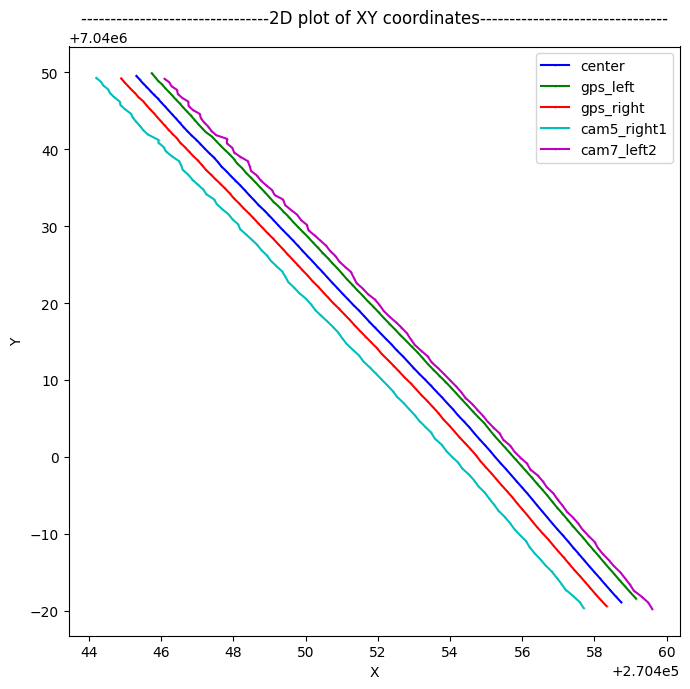

In [124]:
max_index = 100

gps_left = [frame.left_point for frame in data]
gps_right = [frame.right_point for frame in data]
center = [frame.center for frame in data[:max_index]]
#test = [frame.get_rotation_matrix() @ (np.linalg.norm(frame.get_translation_matrix() @ np.array([0,0,0,1])) * np.array([1,1,1,0])) for frame in data[:max_index]]

cam1_pos = [c5_r1.get_camera_position(frame) for frame in data[:max_index]]
cam2_pos = [c7_l2.get_camera_position(frame) for frame in data[:max_index]]

plot_coordinates([center[:max_index], gps_left[:max_index], gps_right[:max_index], cam1_pos, cam2_pos], 
        labels=["center", "gps_left", "gps_right", c5_r1.decription, c7_l2.decription], figsize=(7, 7), is3D=False)



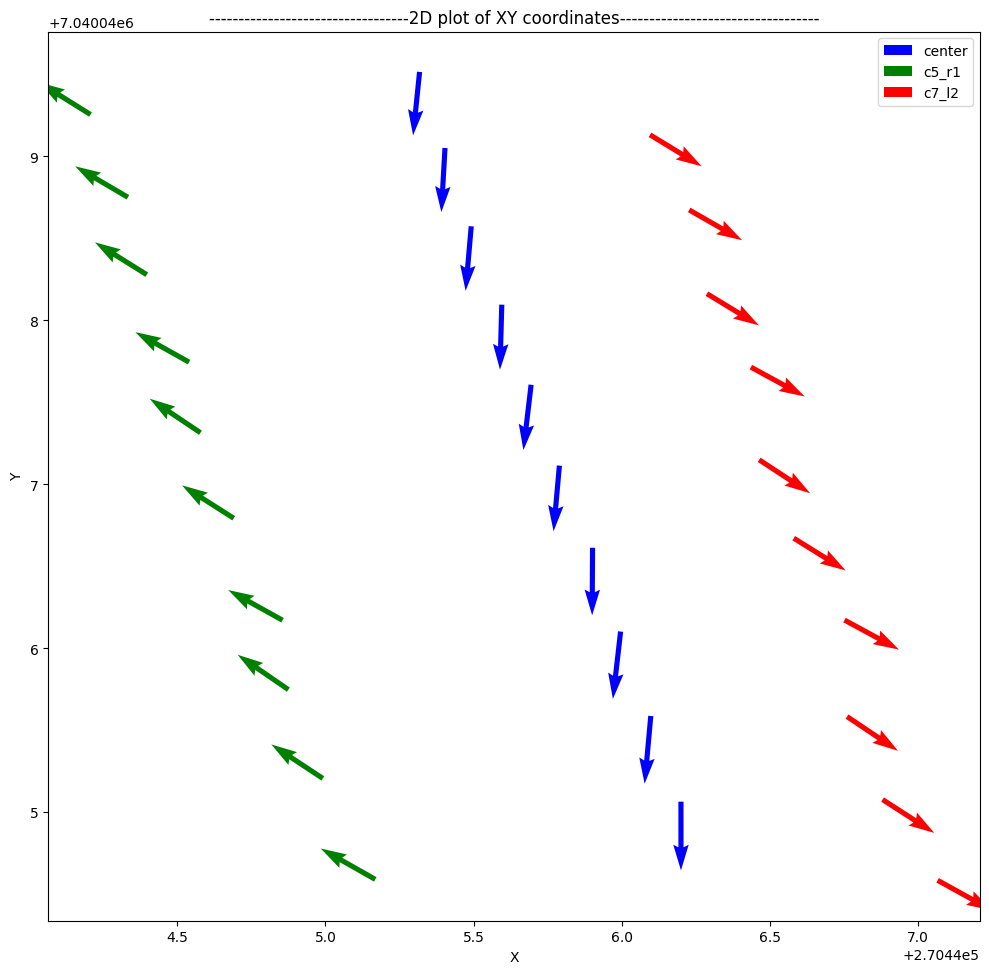

In [125]:
max_index = 10
cardir = [frame.get_rotation_matrix() @ np.array([1,0,0,1]) for frame in data][:max_index]
dir1 = [c5_r1.get_camera_direction_vector(frame) for frame in data][:max_index]
dir2 = [c7_l2.get_camera_direction_vector(frame) for frame in data][:max_index]

directions = [cardir, dir1, dir2]
positions = [center[:max_index], cam1_pos[:max_index], cam2_pos[:max_index]]
labels = ["center", "c5_r1", "c7_l2"]
plot_directions(positions, directions, labels, figsize=(10, 10), is3D=False)
